## NN4 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN4_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN4_Decile_Signal = pd.DataFrame(index=list_company)
df_NN4_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN4_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # NN4 model
    model_nn4 = Sequential()
    model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
    model_nn4.add(Dropout(0.1))
    model_nn4.add(Dense(1, activation='linear')) # Output layer
    model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn4.fit(X_train, y_train, epochs=2, callbacks=[callback])
    y_fair = model_nn4.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN4_Decile_Signal = df_NN4_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [36]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN4_Quintile_Signal = pd.concat([df_199804_199809, df_NN4_Quintile_Signal, df_202206], axis=1)
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.fillna(0).T
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.shift(1).dropna()

df_NN4_Decile_Signal = pd.concat([df_199804_199809, df_NN4_Decile_Signal, df_202206], axis=1)
df_NN4_Decile_Signal = df_NN4_Decile_Signal.fillna(0).T
df_NN4_Decile_Signal = df_NN4_Decile_Signal.shift(1).dropna()

df_NN4_20_Divided_Signal = pd.concat([df_199804_199809, df_NN4_20_Divided_Signal, df_202206], axis=1)
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.fillna(0).T
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.shift(1).dropna()

df_NN4_Percentile_Signal = pd.concat([df_199804_199809, df_NN4_Percentile_Signal, df_202206], axis=1)
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.fillna(0).T
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.shift(1).dropna()

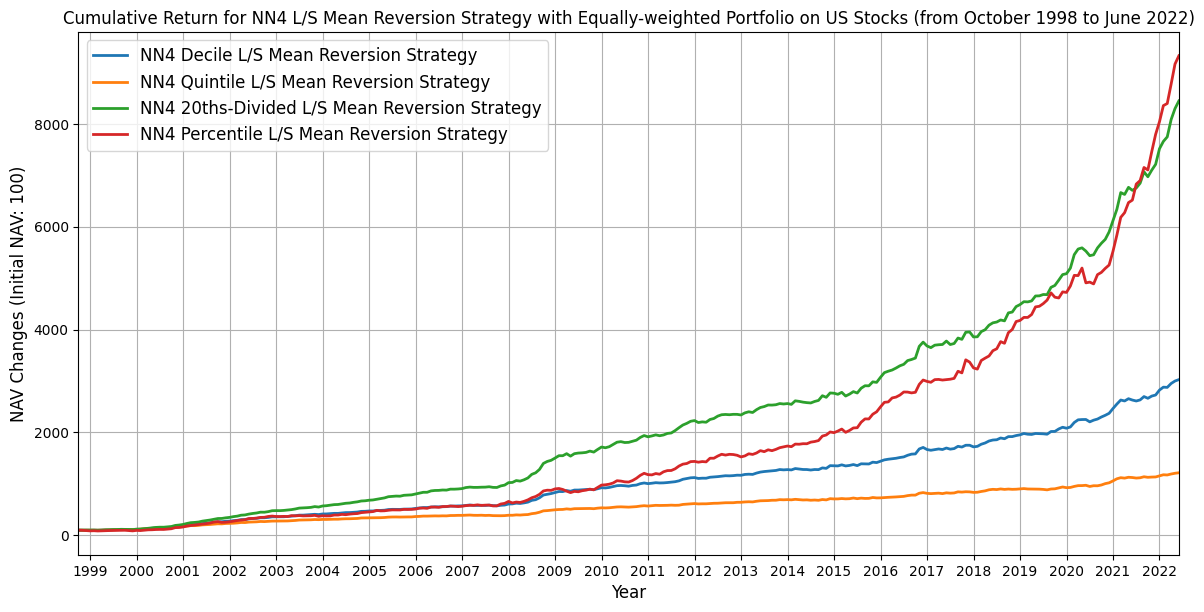

In [189]:
cum_NN4_Q_strategy_return = get_price_df(df_NN4_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_D_strategy_return = get_price_df(df_NN4_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_T_strategy_return = get_price_df(df_NN4_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_P_strategy_return = get_price_df(df_NN4_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN4_strategy_return = pd.concat([cum_NN4_D_strategy_return.rename('NN4 Decile L/S Mean Reversion Strategy'),
                                     cum_NN4_Q_strategy_return.rename('NN4 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN4_T_strategy_return.rename('NN4 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN4_P_strategy_return.rename('NN4 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN4_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN4 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [228]:
# Performance Stats
stats_NN4_Q = get_performance_stats(cum_NN4_Q_strategy_return, rfr=risk_free_rate_df, label='NN4 Quintile (Initial NAV: 100)')
stats_NN4_D = get_performance_stats(cum_NN4_D_strategy_return, rfr=risk_free_rate_df, label='NN4 Decile (Initial NAV: 100)')
stats_NN4_T = get_performance_stats(cum_NN4_T_strategy_return, rfr=risk_free_rate_df, label='NN4 20ths (Initial NAV: 100)')
stats_NN4_P = get_performance_stats(cum_NN4_P_strategy_return, rfr=risk_free_rate_df, label='NN4 Percentile (Initial NAV: 100)')
NN4_stats = pd.concat([stats_NN4_Q, stats_NN4_D, stats_NN4_T, stats_NN4_P], axis=0)
display(NN4_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN4 Quintile (Initial NAV: 100),11.073966,0.110584,0.018682,0.049570,1.853966,0.886015,1.350419,1207.396572,2022-06-30,0.028728,2019-02-28,2019-08-31,2019-11-30,275
NN4 Decile (Initial NAV: 100),29.592416,0.154921,0.018682,0.061530,2.214166,0.971289,1.804169,3059.241598,2022-06-30,0.034363,2020-04-30,2020-07-31,2020-10-31,184
NN4 20ths (Initial NAV: 100),90.562877,0.209480,0.018682,0.071539,2.667041,0.943901,1.863831,9156.287657,2022-06-30,0.029582,2020-04-30,2020-07-31,2020-10-31,184
NN4 Percentile (Initial NAV: 100),120.682577,0.224050,0.018682,0.096405,2.130257,0.174948,0.862964,12168.257663,2022-06-30,0.045187,2020-03-31,2020-06-30,2020-09-30,183


In [229]:
stats2_NN4_Q = get_performance_stats_2(df_NN4_Quintile_Signal, df_returns, df_market_cap, label='NN4 Quintile', model_type='ML')
stats2_NN4_D = get_performance_stats_2(df_NN4_Decile_Signal, df_returns, df_market_cap, label='NN4 Decile', model_type='ML')
stats2_NN4_T = get_performance_stats_2(df_NN4_20_Divided_Signal, df_returns, df_market_cap, label='NN4 20ths', model_type='ML')
stats2_NN4_P = get_performance_stats_2(df_NN4_Percentile_Signal, df_returns, df_market_cap, label='NN4 Percentile', model_type='ML')
NN4_stats2 = pd.concat([stats2_NN4_Q, stats2_NN4_D, stats2_NN4_T, stats2_NN4_P], axis=0)
display(NN4_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN4 Quintile (Long & Short),11.073966,0.008779,3.549626e+10,0.710345,0.092117,-0.077589,0.506937,0.521510,0.494674,310.058621
(Long Position),1319.789306,0.025535,7.176343e+08,0.710345,0.103175,-0.073395,0.569542,0.589480,0.553032,148.082759
(Short Position),-0.944813,-0.010114,6.758440e+10,0.372414,0.065184,-0.071630,0.449454,0.460133,0.440335,162.331034
NN4 Decile (Long & Short),29.592416,0.012075,6.021679e+10,0.744828,0.092874,-0.074339,0.519359,0.538336,0.503573,224.675862
(Long Position),8912.793250,0.032428,5.763279e+08,0.748276,0.103491,-0.064066,0.594950,0.628187,0.568093,113.610345
(Short Position),-0.947923,-0.010315,1.124679e+11,0.393103,0.066146,-0.073100,0.453556,0.462406,0.446006,111.113793
NN4 20ths (Long & Short),90.562877,0.015975,1.037590e+11,0.782759,0.093798,-0.071350,0.539662,0.562907,0.520561,150.010345
(Long Position),88805.359640,0.040790,6.013138e+08,0.837931,0.103729,-0.051928,0.641832,0.693816,0.600975,85.303448
(Short Position),-0.955461,-0.010858,1.878496e+11,0.393103,0.067432,-0.075255,0.456963,0.461527,0.453076,64.710345
NN4 Percentile (Long & Short),120.682577,0.016990,3.446433e+11,0.737931,0.093344,-0.077177,0.578313,0.580282,0.576616,44.951724


In [54]:
cum_NN4_Q_strategy_return_L = get_price_df(df_NN4_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_Q_strategy_return_S = get_price_df(df_NN4_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_L = get_price_df(df_NN4_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_S = get_price_df(df_NN4_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN4_Q_L = get_performance_stats(cum_NN4_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Quintile L (Initial NAV: 100)')
stats_NN4_Q_S = get_performance_stats(cum_NN4_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Quintile S (Initial NAV: 100)')
stats_NN4_D_L = get_performance_stats(cum_NN4_D_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Decile L (Initial NAV: 100)')
stats_NN4_D_S = get_performance_stats(cum_NN4_D_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Decile S (Initial NAV: 100)')
NN4_stats3 = pd.concat([stats_NN4_Q_L, stats_NN4_Q_S, stats_NN4_D_L, stats_NN4_D_S], axis=0)
display(NN4_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN4 Quintile L (Initial NAV: 100),1290.207151,0.352039,0.018682,0.168721,1.975784,0.366861,0.680629,146947.596653,2021-10-31,0.121315,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN4 Quintile S (Initial NAV: 100),7.509980,0.094347,0.018682,0.171001,0.442479,-0.540919,1.247910,1135.309600,2021-10-31,0.250426,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN4 Decile L (Initial NAV: 100),8722.689084,0.465292,0.018682,0.153980,2.900444,0.660718,1.079182,936993.216410,2022-03-31,0.068970,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN4 Decile S (Initial NAV: 100),7.553838,0.094583,0.018682,0.180140,0.421344,-0.378699,1.100497,1173.133831,2021-10-31,0.270856,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [70]:
validation_date = ['1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [71]:
def creating_nn4(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit11 = hp.Int('lay4',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn4 = kt.Hyperband(creating_nn4, objective='val_loss', max_epochs=50, project_name='nn4_tuning_1', overwrite=True)
tuner_nn4.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn4.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 11
lay1: 4
lay2: 15
lay3: 17
lay4: 16
dropout1: 0.3
dropout2: 0.3
dropout3: 0.4
dropout4: 0.4
dropout5: 0.1
regularization: 0.01
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 2
"""

### (3) Feature Importance

In [ ]:
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

nn4_importances_df = pd.DataFrame(index=feature_names)

for i in list_1:
    # NN4 model
    model_nn4 = Sequential()
    model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
    model_nn4.add(Dropout(0.1))
    model_nn4.add(Dense(1, activation='linear')) # Output layer
    model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn4.fit(X_train, y_train)
    perm_nn4 = PermutationImportance(model_nn4, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
    nn4_importances_1 = pd.Series(perm_nn4.feature_importances_, index=feature_names)
    nn4_f = nn4_importances_1 / abs(nn4_importances_1).sum()
    nn4_importances_df = pd.concat([nn4_importances_df, nn4_f], axis=1)

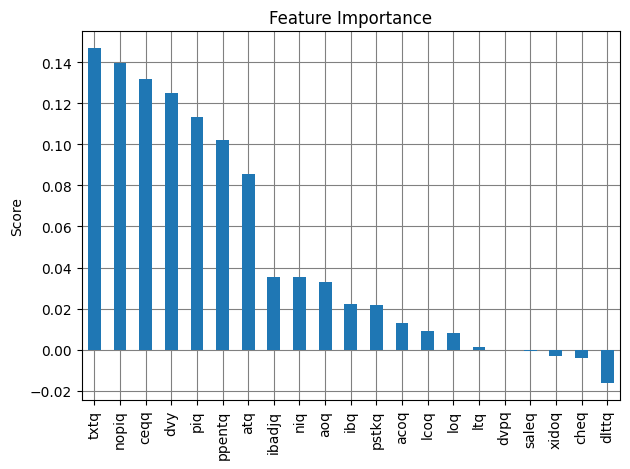

In [378]:
nn4_avg_importance = nn4_importances_df.mean(axis=1).sort_values(ascending=False)
fig, ax4 = plt.subplots()
nn4_avg_importance.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()